# AG News: MLM Insertion

In [13]:
import json
import heapq
import os
import random
from typing import List

%pip install -U datasets
%pip install transformers
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


plt.style.use('fivethirtyeight')

ROOT_DIR = "drive/My Drive/Colab Notebooks/nlp/results/twitter_mlm_insertion"
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)

Requirement already up-to-date: datasets in /usr/local/lib/python3.6/dist-packages (1.1.2)


## Defining augmentation function

In [3]:
class MLMInsertionAugmenter:
    def __init__(self, model, tokenizer, p: float, min_mask: int = 1, topk: int = 5, uniform: bool = False, device=None):
        self.model = model.eval()
        self.tokenizer = tokenizer
        self.vocab_words = list(tokenizer.get_vocab().keys())
        self.mask_token = tokenizer.mask_token
        self.mask_token_id = tokenizer.mask_token_id
        self.topk = topk
        self.min_mask = min_mask
        self.uniform = uniform
        self.p = p
        self.device = device or torch.device('cpu')
        
    def __call__(self, text: str):
        words = np.array(text.split(), dtype='object')
        n_mask = max(self.min_mask, int(len(words) * self.p))
        masked_indices = np.sort(np.random.choice(len(words) + 1, size=n_mask))

        masked_words = np.insert(words, masked_indices, self.mask_token)
        masked_text = " ".join(masked_words)
        
        tokenizer_output = self.tokenizer([masked_text])
        input_ids = torch.tensor(tokenizer_output['input_ids']).to(self.device)
        attention_mask = torch.tensor(tokenizer_output['attention_mask']).to(self.device)
        with torch.no_grad():
            output = self.model(input_ids)
            predicted_logits = output.logits[input_ids == self.mask_token_id]
            predicted_probas = predicted_logits.softmax(1)
            
        predicted_words = [self.sample_word(probas).strip() for probas in predicted_probas]
        
        new_words = np.insert(words, masked_indices, predicted_words)
        new_text = " ".join(new_words)
        return new_text
    
    
    def sample_word(self, predicted_probas):
        if hasattr(predicted_probas, 'tolist'):
            predicted_probas = predicted_probas.tolist()
        most_probable = heapq.nlargest(self.topk, zip(self.vocab_words, predicted_probas), key=lambda t: t[1])
        words, probas = zip(*most_probable)
        word = random.choice(words) if self.uniform else random.choices(words, weights=probas)[0]
        return self.tokenizer.convert_tokens_to_string(word).strip()

In [4]:
class DatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, dataset, augmenter, augmentation_prob: float = 0.9):
        self.dataset = dataset
        self.augmenter = augmenter
        self.augmentation_prob = augmentation_prob

    def __getitem__(self, i):
        item = self.dataset[i]
        if random.random() < self.augmentation_prob:
            item['text'] = self.augmenter(item['text'])
        return item

    def __len__(self):
        return len(self.dataset)


def get_datasets(dataset_name, augmenter, train_size, val_size=5_000, test_size=None, augmentation_prob=0.5, random_seed: int = 42):
    """Returns """
    dataset = load_dataset(dataset_name, split="train")
    test_dataset = load_dataset(dataset_name, split="test")
    # We want test and validation data to be the same for every experiment
    if test_size:
        test_dataset = test_dataset.train_test_split(test_size=test_size, seed=random_seed)["test"]
    train_val_split = dataset.train_test_split(test_size=val_size, seed=random_seed)
    # Validation and test sets
    train_dataset = train_val_split["train"].train_test_split(train_size=train_size, seed=random_seed)["train"]
    train_dataset = DatasetWithAugmentation(train_dataset, augmenter, augmentation_prob=augmentation_prob)
    val_dataset = train_val_split["test"]
    return train_dataset, val_dataset, test_dataset


class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, examples: List[dict]):
        labels = [example['label'] for example in examples]
        texts = [example['text'] for example in examples]
        tokenizer_output = self.tokenizer(texts, truncation=True, padding=True)
        return {
            'labels': torch.tensor(labels), 
            'input_ids': torch.tensor(tokenizer_output['input_ids']), 
            'attention_mask': torch.tensor(tokenizer_output['attention_mask'])
            }


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, micro_f1, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'micro_f1': micro_f1,
        'micro_precision': precision,
        'micro_recall': recall,
        'macro_f1': macro_f1
    }

In [5]:
AUGMENTATION_PROB = 0.5

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)  # we cannot use Fast tokenizer for MLMInsertionAugmenter
data_collator = DataCollator(tokenizer)

device = torch.device('cuda')
mlm_model = AutoModelForMaskedLM.from_pretrained('roberta-base', return_dict=True).eval().to(device)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, 0.2, min_mask=1, topk=10, uniform=False, device=device)

In [7]:
augmenter('I love you')

'I love seeing you'

In [8]:
train_size = 1000

FRACTIONS = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
accuracies = list()

for fraction in FRACTIONS:
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', return_dict=True, num_labels=4)
    augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, fraction, min_mask=1, topk=10, uniform=False, device=device)

    train_dataset, val_dataset, test_dataset = get_datasets("ag_news", augmenter, train_size, val_size=5_000, augmentation_prob=AUGMENTATION_PROB)
    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    print(f"Augmentation fraction: {fraction}")
    print(train_dataset[0])
    print(val_dataset[0])
    print(test_dataset[0])
    output_dir = os.path.join(ROOT_DIR, f"train_size_{train_size}_augmentation_fraction_{fraction}")

    num_train_epochs = 7

    # https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
    training_args = TrainingArguments(
        learning_rate=3e-5,
        weight_decay=0.01,
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=0,  # don't have any intuition for the right value here
        logging_dir=output_dir,
        logging_steps=32,
        load_best_model_at_end=True,
        evaluation_strategy='epoch',
        remove_unused_columns=False,
        no_cuda=False,
        metric_for_best_model="eval_accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
        
    )

    trainer.train()

    test_result = trainer.evaluate(test_dataset)
    

    print(test_result)
    accuracies.append(test_result['eval_accuracy'])

    with open(os.path.join(output_dir, 'test_result.json'), 'w') as f:
        json.dump(test_result, f, indent=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.01
{'label': 3, 'text': 'Study: High-tech firms praised for online customer respect While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission. </s>'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.020148,0.338581,0.892400,0.892400,0.892400,0.892400,0.891374
2,0.272019,0.379621,0.898000,0.898000,0.898000,0.898000,0.896810
3,0.167371,0.458887,0.890600,0.890600,0.890600,0.890600,0.888541
4,0.115211,0.433138,0.902800,0.902800,0.902800,0.902800,0.901655
5,0.090819,0.525124,0.897600,0.897600,0.897600,0.897600,0.896893
6,0.032462,0.533387,0.896400,0.896400,0.896400,0.896400,0.895812
7,0.030292,0.539328,0.896400,0.896400,0.896400,0.896400,0.895797


{'eval_loss': 0.4384109675884247, 'eval_accuracy': 0.8990789473684211, 'eval_micro_f1': 0.8990789473684211, 'eval_micro_precision': 0.8990789473684211, 'eval_micro_recall': 0.8990789473684211, 'eval_macro_f1': 0.898749358348329, 'epoch': 7.0, 'total_flos': 521639885135040}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.1
{'label': 3, 'text': 'Study: High-tech firms praised for online customer respect While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.085747,0.333926,0.889200,0.889200,0.889200,0.889200,0.888038
2,0.291454,0.416902,0.895600,0.895600,0.895600,0.895600,0.894526
3,0.150313,0.438738,0.898600,0.898600,0.898600,0.898600,0.897860
4,0.103077,0.469527,0.893600,0.893600,0.893600,0.893600,0.891664
5,0.080858,0.509908,0.896400,0.896400,0.896400,0.896400,0.895520
6,0.043465,0.528000,0.898000,0.898000,0.898000,0.898000,0.897222
7,0.020246,0.545550,0.893400,0.893400,0.893400,0.893400,0.892851


{'eval_loss': 0.4386281967163086, 'eval_accuracy': 0.900921052631579, 'eval_micro_f1': 0.900921052631579, 'eval_micro_precision': 0.900921052631579, 'eval_micro_recall': 0.900921052631579, 'eval_macro_f1': 0.9009315612557807, 'epoch': 7.0, 'total_flos': 533085628098432}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.15
{'label': 3, 'text': 'Study: High-tech firms praised for online customer respect While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.076955,0.343766,0.892000,0.892000,0.892000,0.892000,0.891125
2,0.312051,0.387500,0.899000,0.899000,0.899000,0.899000,0.898111
3,0.229256,0.450047,0.893200,0.893200,0.893200,0.893200,0.891514
4,0.143407,0.445544,0.894600,0.894600,0.894600,0.894600,0.893529
5,0.080883,0.528602,0.894400,0.894400,0.894400,0.894400,0.893708
6,0.041424,0.594587,0.887400,0.887400,0.887400,0.887400,0.886700
7,0.029228,0.572906,0.892600,0.892600,0.892600,0.892600,0.891889


{'eval_loss': 0.3811330795288086, 'eval_accuracy': 0.8994736842105263, 'eval_micro_f1': 0.8994736842105263, 'eval_micro_precision': 0.8994736842105263, 'eval_micro_recall': 0.8994736842105263, 'eval_macro_f1': 0.8994801678260571, 'epoch': 7.0, 'total_flos': 541204746342720}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.2
{'label': 3, 'text': 'Study: High-tech firms praised for online customer respect While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.043505,0.335528,0.890800,0.890800,0.890800,0.890800,0.889724
2,0.283229,0.385604,0.899200,0.899200,0.899200,0.899200,0.897686
3,0.201062,0.532861,0.883000,0.883000,0.883000,0.883000,0.879746
4,0.108211,0.500681,0.888800,0.888800,0.888800,0.888800,0.887198
5,0.078549,0.532912,0.895200,0.895200,0.895200,0.895200,0.894250
6,0.051241,0.600502,0.889200,0.889200,0.889200,0.889200,0.888355
7,0.033548,0.585601,0.894000,0.894000,0.894000,0.894000,0.893155


{'eval_loss': 0.3890441954135895, 'eval_accuracy': 0.8994736842105263, 'eval_micro_f1': 0.8994736842105263, 'eval_micro_precision': 0.8994736842105263, 'eval_micro_recall': 0.8994736842105263, 'eval_macro_f1': 0.8989748134827243, 'epoch': 7.0, 'total_flos': 549030690825792}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.25
{'label': 3, 'text': 'Study: High-tech firms are praised online for having of online customer respect While many high-tech firms have scored well in a new study of how well they treat customers online, more than a full third of the surveyed companies still routinely share personal data without their permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.034505,0.326147,0.897000,0.897000,0.897000,0.897000,0.895816
2,0.274696,0.413627,0.884400,0.884400,0.884400,0.884400,0.884167
3,0.208459,0.422043,0.899200,0.899200,0.899200,0.899200,0.897847
4,0.122627,0.463217,0.898000,0.898000,0.898000,0.898000,0.897143
5,0.087497,0.499697,0.898600,0.898600,0.898600,0.898600,0.897577
6,0.045072,0.549655,0.893000,0.893000,0.893000,0.893000,0.892434
7,0.050220,0.544137,0.895800,0.895800,0.895800,0.895800,0.894991


{'eval_loss': 0.43237581849098206, 'eval_accuracy': 0.8978947368421053, 'eval_micro_f1': 0.8978947368421053, 'eval_micro_precision': 0.8978947368421053, 'eval_micro_recall': 0.8978947368421053, 'eval_macro_f1': 0.8977079834037273, 'epoch': 7.0, 'total_flos': 558920817913344}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.3
{'label': 3, 'text': 'Study: High-tech firms still praised for online customer respect While many American high-tech firms scored well in a new study because of how they treat customers online, more heavily than a third percent of the surveyed companies still share their own personal browsing data -- without their permission. Bloomberg'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.052097,0.351068,0.879800,0.879800,0.879800,0.879800,0.878320
2,0.324054,0.454886,0.871200,0.871200,0.871200,0.871200,0.870124
3,0.190646,0.404573,0.898600,0.898600,0.898600,0.898600,0.897214
4,0.143448,0.431504,0.892800,0.892800,0.892800,0.892800,0.891842
5,0.099777,0.497693,0.899400,0.899400,0.899400,0.899400,0.897993
6,0.052760,0.545629,0.894400,0.894400,0.894400,0.894400,0.893607
7,0.046669,0.538941,0.896800,0.896800,0.896800,0.896800,0.896145


{'eval_loss': 0.504808783531189, 'eval_accuracy': 0.8998684210526315, 'eval_micro_f1': 0.8998684210526315, 'eval_micro_precision': 0.8998684210526315, 'eval_micro_recall': 0.8998684210526315, 'eval_macro_f1': 0.8992857316042822, 'epoch': 7.0, 'total_flos': 568505804963712}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.4
{'label': 3, 'text': 'Study: Most High-tech firms praised more for handling online with customer respect While many high-tech tech firms have scored quite well , in a sweeping new study of how they treat customers treated online, in more than than a third out of the surveyed technology companies still share personal data online without permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,0.989870,0.342036,0.888800,0.888800,0.888800,0.888800,0.887403
2,0.296825,0.375268,0.897600,0.897600,0.897600,0.897600,0.896781
3,0.215707,0.394140,0.897600,0.897600,0.897600,0.897600,0.895807
4,0.111277,0.437126,0.900200,0.900200,0.900200,0.900200,0.898946
5,0.091568,0.496221,0.900000,0.900000,0.900000,0.900000,0.898658
6,0.027712,0.541537,0.896200,0.896200,0.896200,0.896200,0.895493
7,0.019036,0.535753,0.899000,0.899000,0.899000,0.899000,0.898172


{'eval_loss': 0.43537232279777527, 'eval_accuracy': 0.9003947368421052, 'eval_micro_f1': 0.9003947368421052, 'eval_micro_precision': 0.9003947368421052, 'eval_micro_recall': 0.9003947368421052, 'eval_macro_f1': 0.8999553589925642, 'epoch': 7.0, 'total_flos': 590834875920000}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.5
{'label': 3, 'text': 'Study: High-tech tech firms praised for online customer information respect While many US high-tech firms have scored the ably well , in a relatively new study , of customers how they should treat customers online, found showed more than a quarter third majority of the surveyed companies still share personal customer data sometimes without permission. </s> Advertisement'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.080442,0.347550,0.890200,0.890200,0.890200,0.890200,0.889059
2,0.295820,0.402843,0.896400,0.896400,0.896400,0.896400,0.895388
3,0.204686,0.441853,0.896400,0.896400,0.896400,0.896400,0.894436
4,0.130752,0.431795,0.899400,0.899400,0.899400,0.899400,0.897799
5,0.117960,0.473886,0.901600,0.901600,0.901600,0.901600,0.900320
6,0.065277,0.511074,0.895400,0.895400,0.895400,0.895400,0.894641
7,0.043268,0.515341,0.898400,0.898400,0.898400,0.898400,0.897760


{'eval_loss': 0.47995609045028687, 'eval_accuracy': 0.901578947368421, 'eval_micro_f1': 0.901578947368421, 'eval_micro_precision': 0.901578947368421, 'eval_micro_recall': 0.901578947368421, 'eval_macro_f1': 0.9013605170169923, 'epoch': 7.0, 'total_flos': 610698894026880}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.6
{'label': 3, 'text': 'Study: High-tech firms praised best for showing on online customer respect While many US high-tech firms scored high as well received in a a new Harvard study of the how they would treat customers online, in more than half a quarter and third of all the companies surveyed , companies still share their personal location data without permission. Read Advertisement'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.070023,0.340561,0.889200,0.889200,0.889200,0.889200,0.888314
2,0.302426,0.410830,0.884800,0.884800,0.884800,0.884800,0.884861
3,0.207484,0.426536,0.893400,0.893400,0.893400,0.893400,0.891721
4,0.146251,0.460726,0.887400,0.887400,0.887400,0.887400,0.885490
5,0.125268,0.484938,0.893000,0.893000,0.893000,0.893000,0.891734
6,0.058905,0.553756,0.886000,0.886000,0.886000,0.886000,0.885502
7,0.073028,0.527891,0.892600,0.892600,0.892600,0.892600,0.891873


{'eval_loss': 0.4387001395225525, 'eval_accuracy': 0.8903947368421052, 'eval_micro_f1': 0.8903947368421052, 'eval_micro_precision': 0.8903947368421052, 'eval_micro_recall': 0.8903947368421052, 'eval_macro_f1': 0.8902036175280332, 'epoch': 7.0, 'total_flos': 631364652623616}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 1000, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.7
{'label': 3, 'text': 'Study: High-tech firms praised for online customer respect While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission.'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
1,1.150230,0.342911,0.892000,0.892000,0.892000,0.892000,0.891194
2,0.315760,0.397115,0.890600,0.890600,0.890600,0.890600,0.889578
3,0.227548,0.405416,0.894400,0.894400,0.894400,0.894400,0.893160
4,0.125253,0.495308,0.886800,0.886800,0.886800,0.886800,0.884705
5,0.135469,0.468169,0.898000,0.898000,0.898000,0.898000,0.896971
6,0.073133,0.534484,0.893200,0.893200,0.893200,0.893200,0.892219
7,0.057382,0.528442,0.895800,0.895800,0.895800,0.895800,0.894750


{'eval_loss': 0.4789787828922272, 'eval_accuracy': 0.8982894736842105, 'eval_micro_f1': 0.8982894736842105, 'eval_micro_precision': 0.8982894736842105, 'eval_micro_recall': 0.8982894736842105, 'eval_macro_f1': 0.8982002287176518, 'epoch': 7.0, 'total_flos': 651575692733568}


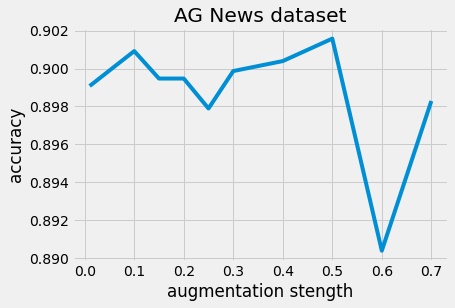

In [17]:
plt.plot(FRACTIONS, accuracies)
plt.xlabel('augmentation stength')
plt.ylabel('accuracy')
plt.title('AG News dataset');